In [1]:
%matplotlib notebook
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import scipy as sp
from scipy.spatial import cKDTree
import pickle
import glob
from donutlib.decamutil import decaminfo
from scriptUtil import decodeNumberList
from astropy.io import fits as pyfits



In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
#input pickle
allFrames = pd.read_pickle("/u/ec/roodman/Astrophysics/Donuts/Meshesv22/Science-20140212s2-v22i2_All.pkl")

In [4]:
allFrames.columns[0:100]

Index(['index', 'EXTEND', 'IFILE', 'FILTER', 'OBSID', 'OBSTYPE', 'ZD', 'HA',
       'EXPTIME', 'RA', 'DEC', 'MSURTEMP', 'MAIRTEMP', 'MJD-OBS', 'EXTNAME',
       'IX', 'IY', 'X_IMAGE', 'Y_IMAGE', 'ISTAMP', 'XDECAM', 'YDECAM',
       'SEX_FLUX', 'SEX_FLGS', 'SEX_ELPT', 'SEX_AVEI', 'CHI2', 'DOF',
       'FITSTAT', 'CLKTIME', 'NCALCALL', 'NCALCDER', 'NELE', 'RZERO', 'BKGD',
       'ZERN2', 'ZERN3', 'ZERN4', 'ZERN5', 'ZERN6', 'ZERN7', 'ZERN8', 'ZERN9',
       'ZERN10', 'ZERN11', 'ZERN12', 'ZERN13', 'ZERN14', 'ZERN15', 'ZERN16',
       'ZERN17', 'ZERN18', 'ZERN19', 'ZERN20', 'ZERN21', 'ZERN22', 'ZERN23',
       'ZERN24', 'ZERN25', 'ZERN26', 'ZERN27', 'ZERN28', 'ZERN29', 'ZERN30',
       'ZERN31', 'ZERN32', 'ZERN33', 'ZERN34', 'ZERN35', 'ZERN36', 'ZERN37',
       'NELEE', 'RZEROE', 'BKGDE', 'ZERN2E', 'ZERN3E', 'ZERN4E', 'ZERN5E',
       'ZERN6E', 'ZERN7E', 'ZERN8E', 'ZERN9E', 'ZERN10E', 'ZERN11E', 'ZERN12E',
       'ZERN13E', 'ZERN14E', 'ZERN15E', 'ZERN16E', 'ZERN17E', 'ZERN18E',
       'ZERN

In [5]:
def mkProfile(xarr,yarr,nx=100,xmin=0.,xmax=1.0,ymin=0.,ymax=1.0,retPlot=True):

    dx = (xmax-xmin)/nx
    bins = np.arange(xmin,xmax,dx)
    ind = np.digitize(xarr,bins)
    xval = []
    xerr = []
    yval = []
    yerr = []
    for i in range(len(bins)-1):

        here = (ind==i)
        ygood = np.logical_and(yarr>=ymin,yarr<=ymax)
        ok = np.logical_and(ygood,here)
        yinthisbin = yarr[ok]
        yhere = np.array(yinthisbin)
        n = len(yinthisbin)
        if n>0:
            xval.append(0.5*(bins[i+1]+bins[i]))
            xerr.append(0.5*(bins[i+1]-bins[i]))
            yval.append(yhere.mean())
            yerr.append(yhere.std()/n)
        #print i,bins[i],bins[i+1],len(yarr),yarr.mean(),n,yarr.std()

    if retPlot:
        profile = plt.errorbar(xval,yval,xerr=xerr,yerr=yerr)
        return profile
    else:
        return xval,yval,xerr,yerr

<IPython.core.display.Javascript object>


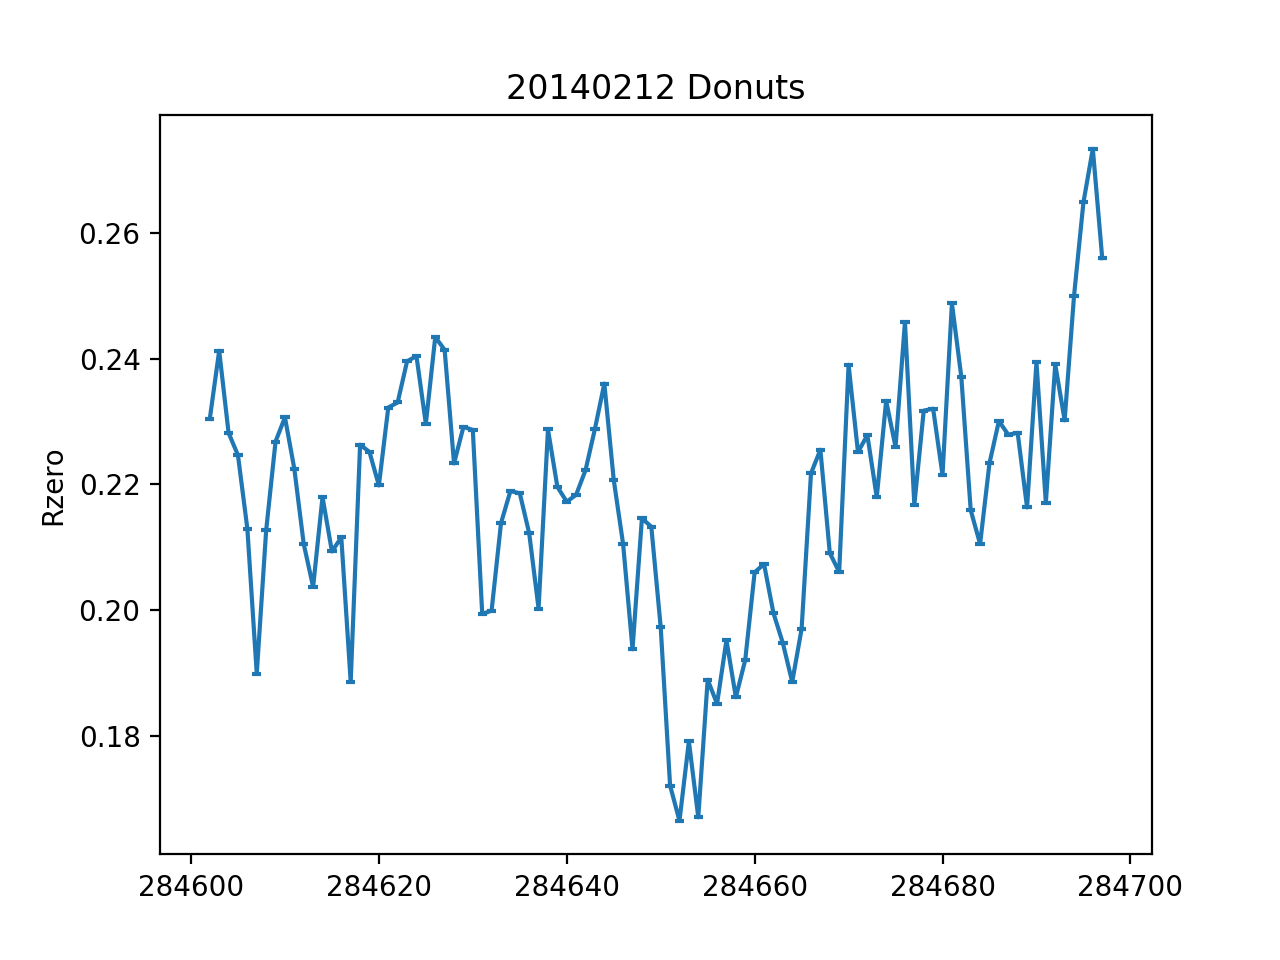

Text(0,0.5,'Rzero')

In [6]:
f,axa = plt.subplots(1,1)
ax = axa
ifile = np.array(allFrames['IFILE'],dtype='float')
rzero = np.array(allFrames['RZERO'],dtype='float')
mkProfile(ifile,rzero,nx=98,xmin=284601.-0.5,xmax=284698.+0.5,ymin=0.,ymax=0.5)
ax.set_title("20140212 Donuts")
ax.set_ylabel("Rzero")

<IPython.core.display.Javascript object>


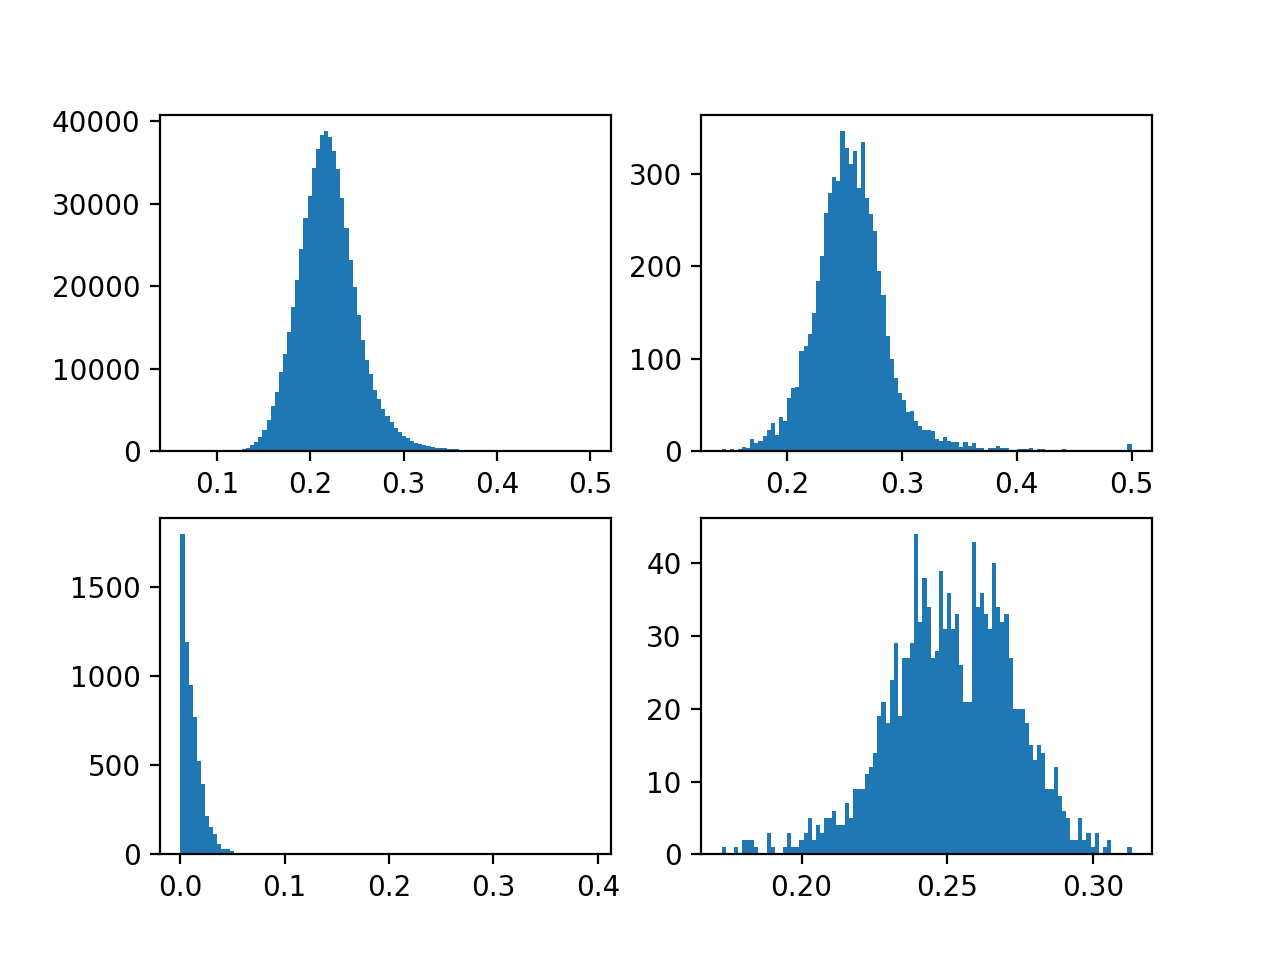

In [7]:
f,axa = plt.subplots(2,2)
ax = axa.flatten()
h = ax[0].hist(allFrames['RZERO'],bins=100)

use = allFrames['IFILE'] == 284696
aF = allFrames[use]
h = ax[1].hist(aF['RZERO'],bins=100)
h = ax[2].hist(aF['RZEROE'],bins=100)
aFg = aF[aF['RZEROE']<0.003]
h = ax[3].hist(aFg['RZERO'],bins=100)

In [8]:
from donutlib.PointMesh import PointMesh
from donutlib.decamutil import decaminfo 

Welcome to JupyROOT 6.14/00


In [9]:
def mkAMesh(title,pointsDataFrame,varName,nInterpGrid=8,myMethod='bmedian',methodVal=None):
    infoObj = decaminfo()
    info = infoObj.infoDict

    # fill PointMesh coordinate list and gridDict
    coordList = []
    gridDict = {}

    for ccd in list(info.keys()):
        ccdinfo = info[ccd]
        if not ccdinfo["FAflag"]:
            coordList.append(ccd)


    # loop over ccds
    for ccd in coordList:
        ccdinfo = info[ccd]
        if ( not ccdinfo["FAflag"] ):

            xlo = ccdinfo["xCenter"] - 1024 * infoObj.mmperpixel
            xhi = ccdinfo["xCenter"] + 1024 * infoObj.mmperpixel
            ylo = ccdinfo["yCenter"] - 2048 * infoObj.mmperpixel
            yhi = ccdinfo["yCenter"] + 2048 * infoObj.mmperpixel

            # fill gridDict
            # 1/31/2014 - make the grid x2 bigger in Y than X, to match CCD sizes!
            gridDict[ccd] = [nInterpGrid,ylo,yhi,nInterpGrid,xlo,xhi]

    theMesh = PointMesh(coordList,gridDict,pointsDataFrame=pointsDataFrame,myMethod=myMethod,methodVal=methodVal,title=title,columnsDataFrame=['EXTNAME','XDECAM','YDECAM',varName])
    return theMesh


In [10]:
aOne = allFrames[(allFrames['IFILE'] == 284692)]
rzero_mesh = mkAMesh("rzero",aOne,'RZERO',nInterpGrid=4)

<IPython.core.display.Javascript object>


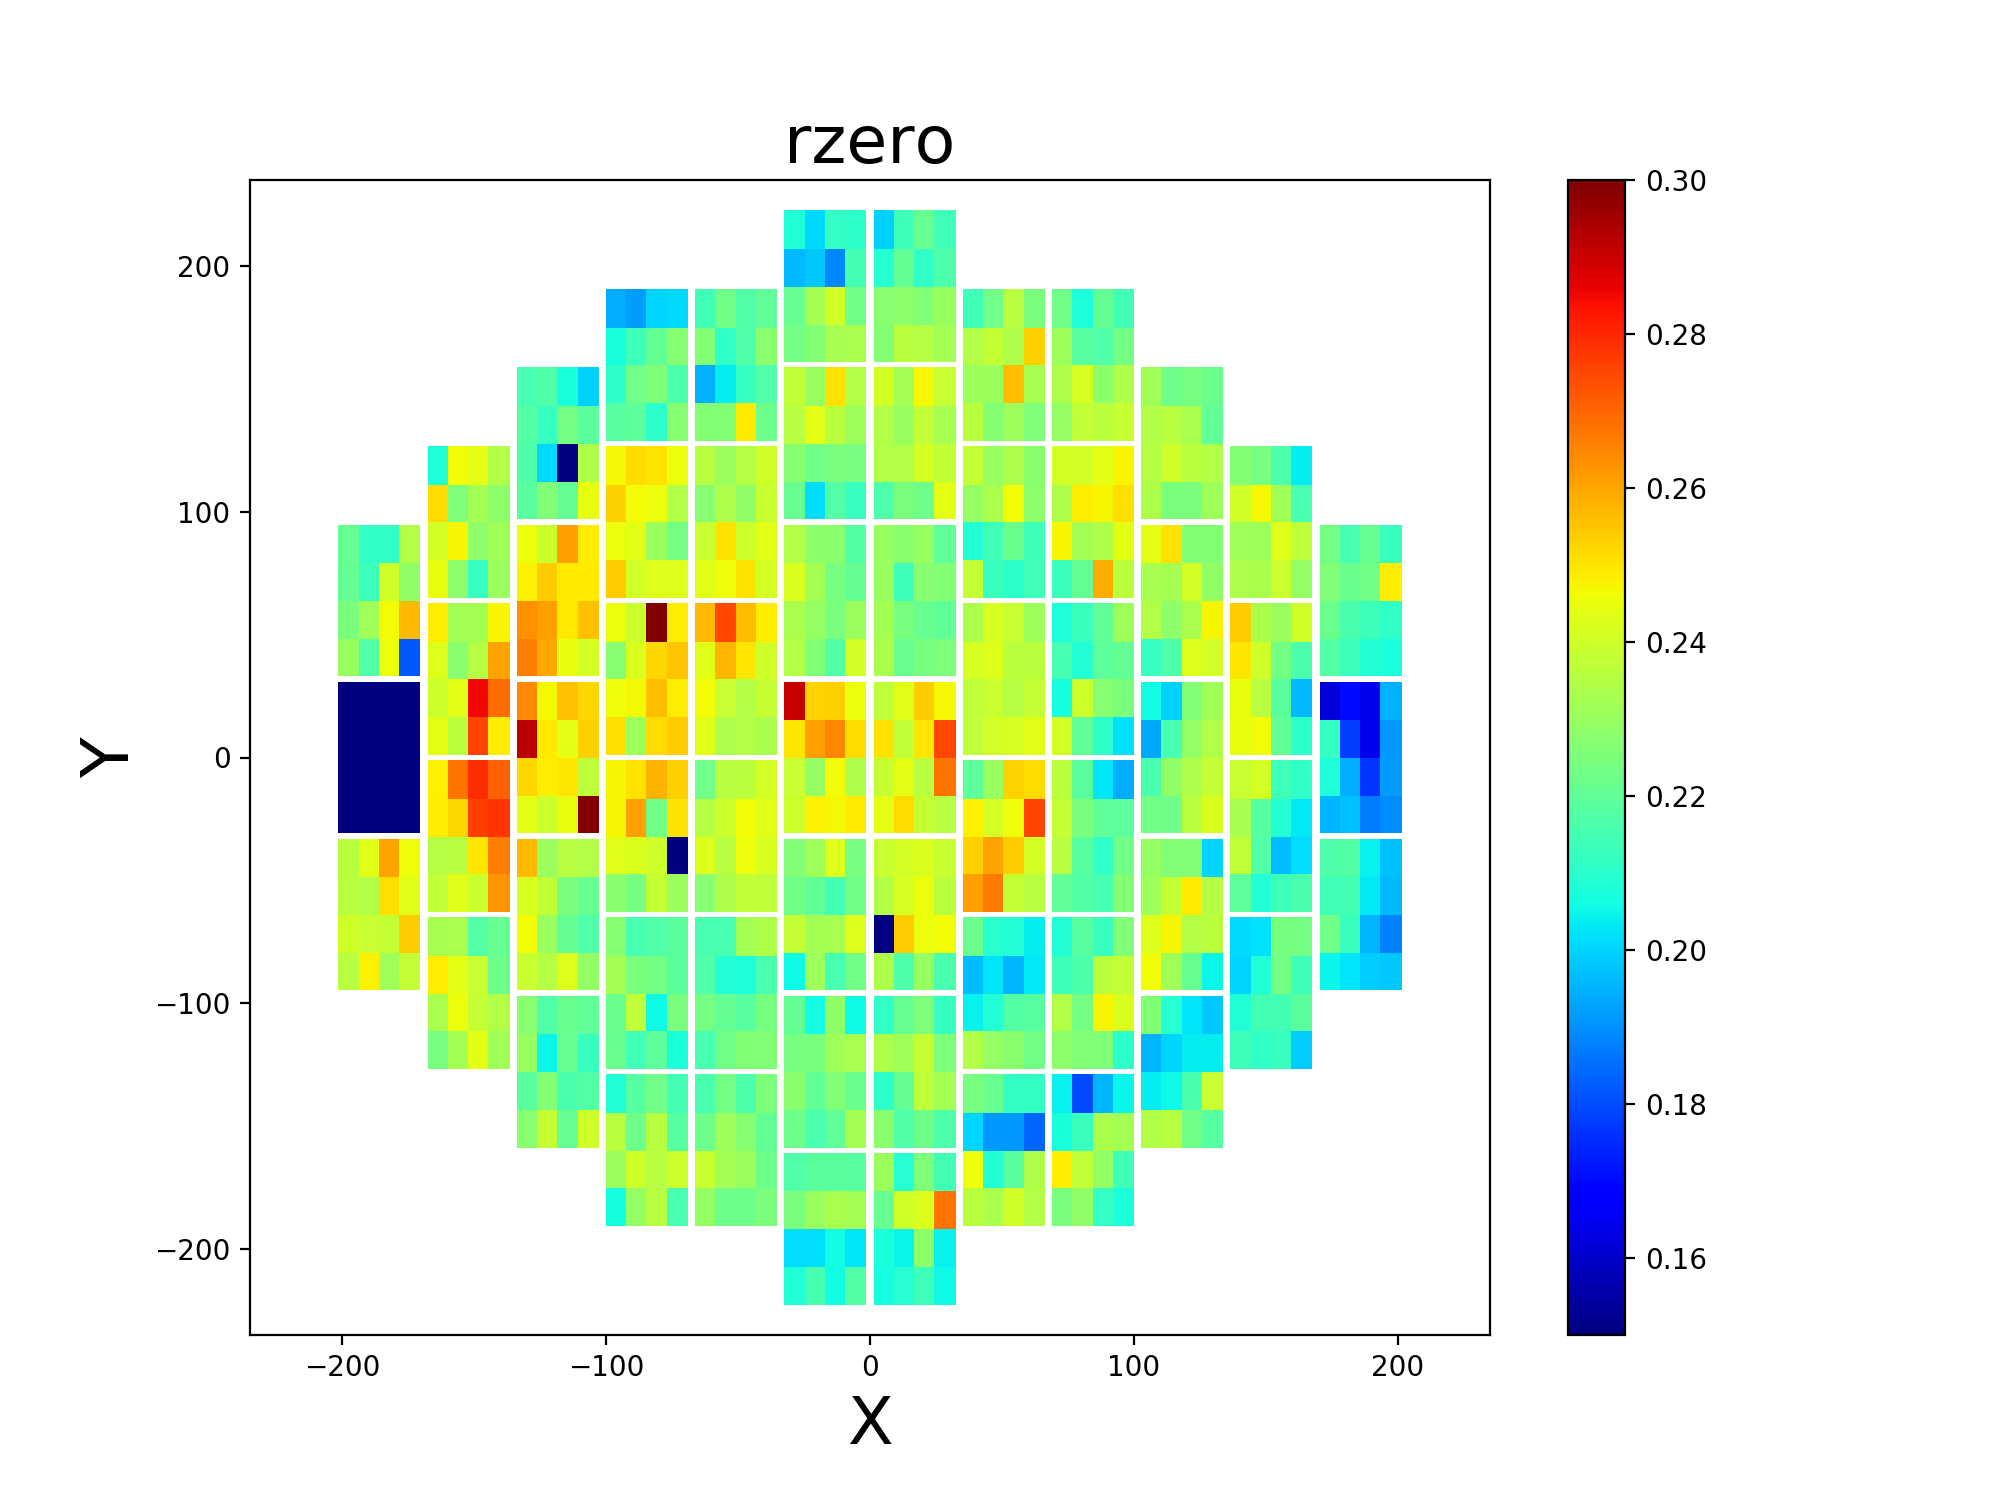

In [11]:
f,a,c = rzero_mesh.plotMeshMPL2D(interactiveFlag=True,zmin=0.15,zmax=0.30)
# plot RZERO vs. Focal plane position, for higher statistics donuts

In [14]:
rzero_mesh_all = mkAMesh("rzero",allFrames,'RZERO',nInterpGrid=8)

In [17]:
f,a,c = rzero_mesh.plotMeshMPL2D(interactiveFlag=True,zmin=0.15,zmax=0.30)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/nfs/slac/g/ki/ki06/roodman/Software/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-4b4e64073f35>", line 1, in <module>
    f,a,c = rzero_mesh.plotMeshMPL2D(interactiveFlag=True,zmin=0.15,zmax=0.30)
  File "/u/ec/roodman/Astrophysics/Code/Donut/donutlib/PointMesh.py", line 852, in plotMeshMPL2D
  File "/nfs/slac/g/ki/ki06/roodman/Software/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py", line 548, in figure
    **kwargs)
  File "/nfs/slac/g/ki/ki06/roodman/Software/anaconda3/lib/python3.6/site-packages/matplotlib/backend_bases.py", line 161, in new_figure_manager
  File "/nfs/slac/g/ki/ki06/roodman/Software/anaconda3/lib/python3.6/site-packages/matplotlib/backends/backend_nbagg.py", line 239, in new_figure_manager_given_figure
  File "/nfs/slac/g/ki/ki06/roodman/Software/anaconda3/lib/python3.6/site-packag

OSError: [Errno 24] Too many open files: '/nfs/slac/g/ki/ki06/roodman/Software/anaconda3/lib/python3.6/site-packages/matplotlib/backends/web_backend/js/mpl.js'

In [18]:
# find high statistics donuts in S4 or N4
aFcenter = aF[(aF['EXTNAME'] == 'S4') & (aF['NELE'] > 5.e6)]

In [19]:
aFcenter[['ISTAMP','EXTNAME','NELE','RZERO','RZEROE','ZERN4']]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/nfs/slac/g/ki/ki06/roodman/Software/anaconda3/lib/python3.6/site-packages/IPython/core/formatters.py", line 224, in catch_format_error
  File "/nfs/slac/g/ki/ki06/roodman/Software/anaconda3/lib/python3.6/site-packages/IPython/core/formatters.py", line 345, in __call__
  File "/nfs/slac/g/ki/ki06/roodman/Software/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py", line 696, in _repr_html_
  File "/nfs/slac/g/ki/ki06/roodman/Software/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py", line 2034, in to_html
  File "/nfs/slac/g/ki/ki06/roodman/Software/anaconda3/lib/python3.6/site-packages/pandas/io/formats/format.py", line 743, in to_html
  File "/nfs/slac/g/ki/ki06/roodman/root6/lib/ROOT.py", line 461, in _importhook
  File "<frozen importlib._bootstrap>", line 971, in _find_and_load
  File "<frozen importlib._bootstrap>", line 955, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 665, in _load_unlocked


OSError: [Errno 24] Too many open files: '/nfs/slac/g/ki/ki06/roodman/Software/anaconda3/lib/python3.6/site-packages/pandas/io/formats/html.py'

       ISTAMP EXTNAME          NELE     RZERO    RZEROE      ZERN4
613112      7      S4  2.300913e+07  0.288272  0.000458  11.046572
613113      8      S4  1.276037e+07  0.288136  0.000635  11.035425
613117     12      S4  1.622632e+07  0.276229  0.000537  11.052842
613120     17      S4  5.381309e+06  0.290897  0.001233  11.059991
613149     50      S4  6.323956e+06  0.281879  0.001077  11.039316
613157     63      S4  7.410834e+06  0.271686  0.000900  11.070286
613177     88      S4  6.966945e+06  0.282712  0.001005  11.039839
613182     93      S4  1.926832e+07  0.270971  0.000456  11.082525
613193    107      S4  6.264598e+06  0.276208  0.001063  10.982037

In [ ]:
#get images of a high stat donut in each exposure, in S4 sensor
aCenter = allFrames[(allFrames['EXTNAME']=='S4')&(allFrames['NELE']>5.e6)]

In [ ]:
target = 8.0e6
useDonuts = {}
for ifile in range(284601,284698+1):
    aOne = aCenter[(aCenter['IFILE'] == ifile)]    
    aOnePick = aOne.iloc[(aOne['NELE']-target).abs().argsort()[:1]]
    print(aOnePick[['IFILE','ISTAMP','EXTNAME','NELE','RZERO','RZEROE','ZERN4']])
    aTwoPick = aOne.iloc[(aOne['NELE']-target).abs().argsort()[1:2]]
    print(aTwoPick[['IFILE','ISTAMP','EXTNAME','NELE','RZERO','RZEROE','ZERN4']])
    useDonuts[ifile] = aOnePick['ISTAMP']

In [ ]:
f,axa = plt.subplots(20,5,figsize=(10,40))
ax = axa.flatten()
prefix = '/nfs/slac/g/ki/ki06/roodman/Donuts/20140212s2'
for ifile in range(284601,284698+1):
    if ifile in useDonuts:
        try:
            name = "%s/%d/v22/DECam_%08d.S4.%04d.second.donut.fits*" % (prefix,ifile,ifile,int(useDonuts[ifile]))
            files = glob.glob(name)
            hdu = pyfits.open(files[0])
            ax[ifile-284601].imshow(hdu[3].data,origin='lower',interpolation='None')
            ax[ifile-284601].tick_params(axis='both',which='both',bottom=False,top=False,labelbottom=False,left=False,right=False,labelleft=False)
            ax[ifile-284601].set_aspect('equal')
        except:
            print(ifile)

f.subplots_adjust(hspace=0,wspace=0,left=0.,right=1.,bottom=0.,top=1.)

In [ ]:
#input pickle
allFramesZ = pd.read_pickle("Meshesv22/Science-20181218s1-v22i2_All.pkl")
#get images of a high stat donut in each exposure, in S4 sensor
aCenterZ = allFramesZ[(allFramesZ['EXTNAME']=='S4')&(allFramesZ['NELE']>5.e6)]

In [ ]:
target = 8.0e6
useDonutsZ = {}
for ifile in range(804523,804572+1):
    aOne = aCenterZ[(aCenterZ['IFILE'] == ifile)]    
    aOnePick = aOne.iloc[(aOne['NELE']-target).abs().argsort()[:1]]
    print(aOnePick[['IFILE','ISTAMP','EXTNAME','NELE','RZERO','RZEROE','ZERN4']])
    useDonutsZ[ifile] = aOnePick['ISTAMP']

In [ ]:
f,axa = plt.subplots(10,5,figsize=(10,20))
ax = axa.flatten()
prefix = '/nfs/slac/g/ki/ki06/roodman/Donuts/20181218s1'
for ifile in range(804523,804572+1):
    if ifile in useDonutsZ:
        try:
            name = "%s/%d/v22/DECam_%08d.S4.%04d.second.donut.fits*" % (prefix,ifile,ifile,int(useDonutsZ[ifile]))
            files = glob.glob(name)
            hdu = pyfits.open(files[0])
            ax[ifile-804523].imshow(hdu[3].data,origin='lower',interpolation='None')
            ax[ifile-804523].tick_params(axis='both',which='both',bottom=False,top=False,labelbottom=False,left=False,right=False,labelleft=False)
            ax[ifile-804523].set_aspect('equal')
        except:
            print(ifile)

f.subplots_adjust(hspace=0,wspace=0,left=0.,right=1.,bottom=0.,top=1.)